In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import warnings; warnings.simplefilter('ignore')
import sys
sys.path.insert(0, '/Users/jsmonzon/Research/SatGen/mcmc/src/')
import jsm_halopull
import jsm_SHMR
import jsm_mcmc
import jsm_stats
import jsm_models

In [2]:
lgMh = np.vstack(np.load("../../../data/MW-analog/meta_data_psi4/models.npz")["mass"])

In [3]:
def covariance(mass_2D, min, max, Nbins, convert=True, sigma=0.2, plot=True, norm=False, negative=False, logspace=False):

    if convert==True:   
        mass_2D_new = jsm_SHMR.general([10.5, 2.0, sigma, 0, 0, 0], mass_2D, 0, 5) # sample sigma 5 times!
        mass_2D = mass_2D_new
        title = f"Nbin = {Nbins}, sigma = {sigma:.2f}, "
        axis_label="log $M_*$"
        #print("working with stellar masses")
    else:
        title = f"Nbin = {Nbins}, "
        axis_label="log $M_H$"

    mass_bins = np.linspace(min, max, Nbins)
    N_ij = np.apply_along_axis(jsm_stats.cumulative, 1, mass_2D, mass_bins) 
    C_ij = np.cov(N_ij.T)

    numerator = np.sum([np.sum(np.diagonal(C_ij, offset=i)) for i in range(1, Nbins)]) # this iterates over the offsets of the diagonal and sums everything!
    denominator = C_ij.trace()
    if numerator< 0:
        print(numerator)
    Qstat = numerator/denominator

    if plot:
        
        if norm==True:
            N_ave = np.average(N_ij, axis=0)
            norm = np.zeros(C_ij.shape)
            for i in range(Nbins-1):
                for j in range(Nbins-1):
                    norm[i, j] = np.sqrt(N_ave[i]*N_ave[j])

            fig,ax=plt.subplots(figsize=(8,8))
            plt.title(title + f"Qstat = {Qstat:.2f}")
            im = ax.imshow(C_ij/norm, extent=[mass_bins.min(), mass_bins.max(), mass_bins.min(), mass_bins.max()], cmap="cividis", origin="lower", vmin=0, vmax=1.5)
            ax.plot(mass_bins, mass_bins, lw=0.5, color="white", ls="-.")
            ax.set_aspect(1/ax.get_data_ratio(), adjustable="box")
            fig.colorbar(im, label="$C_{i,j} / \sqrt{<n_{i}> <n_{j}>}$",  shrink=0.8)
            plt.xlabel(axis_label, fontsize=15)
            plt.ylabel(axis_label, fontsize=15)
            plt.show()

        elif negative==True:
            fig,ax=plt.subplots(figsize=(8,8))
            plt.title(title + f"Qstat = {Qstat:.2f}")
            im = ax.imshow(C_ij>0, extent=[mass_bins.min(), mass_bins.max(), mass_bins.min(), mass_bins.max()], cmap="RdBu", origin="lower")
            ax.plot(mass_bins, mass_bins, lw=0.5, color="white", ls="-.")
            ax.set_aspect(1/ax.get_data_ratio(), adjustable="box")
            plt.xlabel(axis_label, fontsize=15)
            plt.ylabel(axis_label, fontsize=15)
            plt.show()

        elif logspace==True:
            fig,ax=plt.subplots(figsize=(8,8))
            plt.title(title + f"Qstat = {Qstat:.2f}")
            im = ax.imshow(np.log10(C_ij), extent=[mass_bins.min(), mass_bins.max(), mass_bins.min(), mass_bins.max()], cmap="viridis", origin="lower")
            ax.plot(mass_bins, mass_bins, lw=0.5, color="white", ls="-.")
            ax.set_aspect(1/ax.get_data_ratio(), adjustable="box")
            fig.colorbar(im, label="$\log_{10}\ C_{i,j}$",  shrink=0.8)
            plt.xlabel(axis_label, fontsize=15)
            plt.ylabel(axis_label, fontsize=15)
            plt.show()
                          
        
        else:
            fig,ax=plt.subplots(figsize=(8,8))
            plt.title(title + f"Qstat = {Qstat:.2f}")
            im = ax.imshow(C_ij, extent=[mass_bins.min(), mass_bins.max(), mass_bins.min(), mass_bins.max()], cmap="cividis", origin="lower")
            ax.plot(mass_bins, mass_bins, lw=0.5, color="white", ls="-.")
            ax.set_aspect(1/ax.get_data_ratio(), adjustable="box")
            fig.colorbar(im, label="$C_{i,j}$",  shrink=0.8)
            plt.xlabel(axis_label, fontsize=15)
            plt.ylabel(axis_label, fontsize=15)
            plt.show()
            
    return Qstat

### first just the halo masses

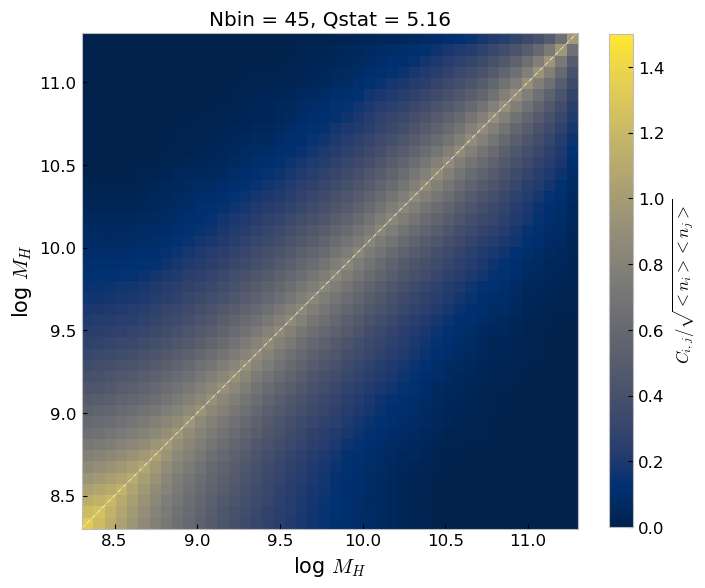

In [4]:
q_halo = covariance(lgMh, 8.3, 11.3, Nbins=45, convert=False, norm=True)

### Now lets play the same game with stellar mass
#### first with the fiducual model

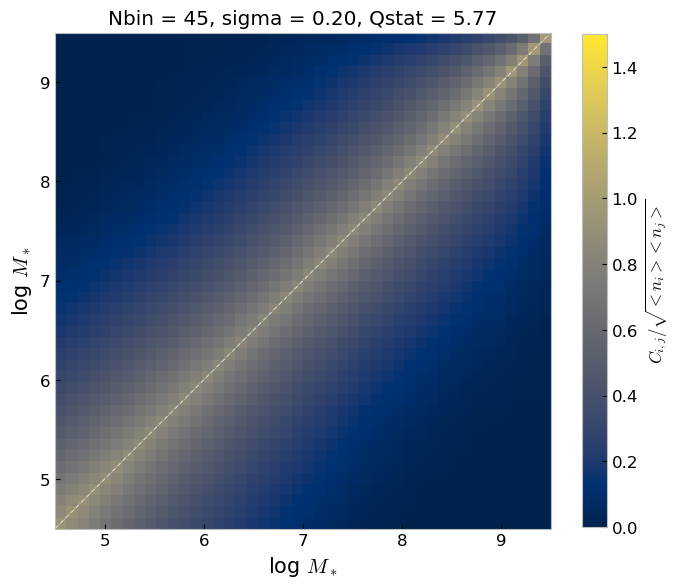

In [18]:
q_determinisitic = covariance(lgMh, 4.5, 9.5, Nbins=45, convert=True, sigma=0.2, norm=True)

#### now lets play with the scatter

In [6]:
sigmas = np.linspace(0.1, 0.8, 25)
qs = []
for sigma in sigmas:
    qs.append(covariance(lgMh, 4.5, 9.5, Nbins=45, convert=True, sigma=sigma, plot=False))

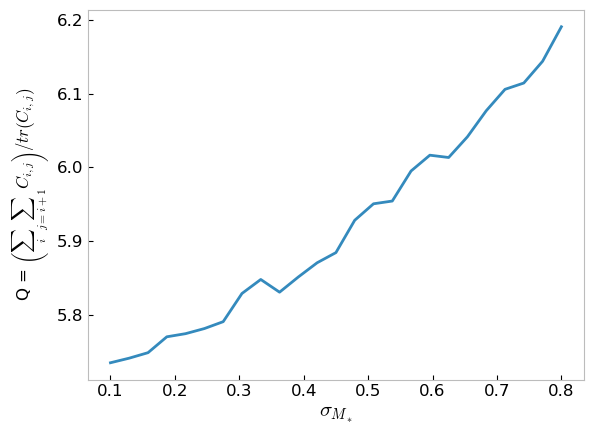

In [7]:
plt.plot(sigmas, qs)
plt.xlabel("$\sigma_{M_*}$", fontsize=15)
plt.ylabel("Q = $\left(\sum_i \sum_{j=i+1} C_{i, j} \\right) / tr\left( C_{i,j}\\right)$")
plt.show()